In [1]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math

from hera_sim import foregrounds, noise, sigchain, rfi

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, StratifiedKFold


In [2]:
def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3

In [6]:
def load_data_cv():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    X, y = dataset, labels
    X = X.astype('float32')
    n_features = (X.shape[1], X.shape[2])
    return X, y, n_features

def load_data():
    # load and configure the dataset
    dataset = np.load('dataset.npy')
    labels = np.load('labels.npy')
    X, y = dataset, labels
    X = X.astype('float32')
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    n_features = (X_train.shape[1], X_train.shape[2])
    # print(n_features)
    return X, y, X_train, y_train, X_test, y_test, n_features

def create_model(n_features):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=n_features))
    model.add(layers.Dense(25, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(8, activation='relu', kernel_initializer='he_normal'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # fit the model
    model.fit(X_train, y_train, epochs=150, batch_size=32, verbose=0)

    # evaluate the model
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print('Test Accuracy: %.3f' % acc)

    # make predictions
    predictions = model.predict_classes(X_test)
    predictions = predictions.flatten()
    # model.summary()
    return acc, predictions

def get_faulty_predictions(predictions, labels):
    my_list = []
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            my_list.append(i)
    return my_list

def print_stats(accs):
    print(np.mean(accs))
    print(np.std(accs))

def show_hist(my_list):
    if isinstance(my_list[0], list):
        from itertools import chain
        my_list = list(chain.from_iterable(my_list))
    bins=np.linspace(0,1200,24)
    print(my_list)
    print(len(my_list))
    plt.hist(my_list, bins=bins)
    plt.xlabel("index in dataset (<200 is clean)")
    plt.ylabel("count")
    plt.title("faulty predictions")
    plt.show()

- ReLu activation function: for x, it returns max(0, x)
- He weight initialization is a good option: https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78

# No Cross-validation

Test Accuracy: 0.985
Test Accuracy: 1.000
Test Accuracy: 0.970
Test Accuracy: 0.985
Test Accuracy: 0.970
Test Accuracy: 0.977
Test Accuracy: 0.947
Test Accuracy: 0.894
Test Accuracy: 0.932
Test Accuracy: 0.992
0.9651515
0.030716881
[0, 1, 3, 7, 8, 9, 13, 14, 16, 18, 19, 21, 23, 26, 33, 36, 37, 40, 41, 46, 49, 50, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 68, 70, 72, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 101, 104, 107, 110, 112, 113, 114, 115, 117, 118, 120, 121, 124, 126, 128, 130, 0, 1, 3, 7, 8, 9, 13, 14, 16, 18, 19, 21, 23, 26, 33, 36, 40, 41, 49, 50, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 68, 70, 72, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 89, 91, 92, 93, 94, 95, 97, 98, 99, 101, 104, 107, 110, 112, 113, 114, 115, 117, 118, 120, 121, 124, 126, 128, 130, 0, 1, 3, 7, 8, 9, 13, 14, 16, 18, 19, 21, 23, 26, 33, 35, 36, 40, 41, 44, 49, 50, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 77, 78, 79, 80, 81, 82, 84, 86, 87, 88, 8

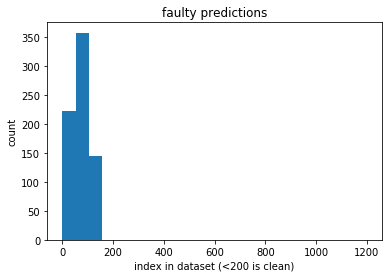

In [7]:
X, y, X_train, y_train, X_test, y_test, n_features = load_data()
faulty_predictions = []
accs = []

for i in range(10):
    model = None
    model = create_model(n_features)
    acc, predictions = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
    accs.append(acc)
    faulty_predictions.append(get_faulty_predictions(predictions, y))

print_stats(accs)
show_hist(faulty_predictions)



In [14]:
print(len(X_test))

132


# Stratified K-fold Cross-validation

In [ ]:
n_splits = 3
X, y, n_features = load_data_cv()
skf = StratifiedKFold(n_splits, shuffle=True)

accs = []
faulty_predictions=[]

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
		# print(len(X[test_index]), len(y[train_index]))
		print("Running Fold", i+1, "/", n_splits)
		model = None # clear the NN
		model = create_model(n_features)
		acc, predictions = train_and_evaluate_model(model, X[train_index], y[train_index], X[test_index], y[test_index])
		accs.append(acc)
		faulty_predictions.append(get_faulty_predictions(predictions, y))

print_stats(accs)
show_hist(faulty_predictions)